# UNISACSI Examples

This notebook contains a set of example scripts showing how the functions of the unisacsi package can be used to read data collected during fieldwork and create plots.

## Importing packages, setting paths, ...

As in every Python script, first import all packages needed for the following code:

In [1]:
import unisacsi.Ocean as Oc
import unisacsi.Meteo as Met
from unisacsi.MET_model_download import download_MET_model_static_fields, download_MET_model_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import gsw
import cmocean as cmo
import glob
import uptide

Then, download the folder with the example and map data and save it locally on your computer. Then, specify this location here:

In [2]:
path_data = "/Users/lukasf/OneDrive - Universitetssenteret på Svalbard AS/unisacsi_example_data/"

Now you are ready to dive into the actual examples!

## Oceanography

### CTD

You can use the read_CTD function from the Ocean module of unisacsi to read one or several CTD data file. If you are unsure how to use it, simply check the docs using the help function (PS: this works for any Python function, if the creator has included documentation):

In [3]:
help(Oc.read_CTD)

Help on function read_CTD in module unisacsi.Ocean:

read_CTD(inpath, cruise_name='cruise', outpath=None, stations=None, salt_corr=(1.0, 0.0), oxy_corr=(1.0, 0.0), use_system_time=False)
    This function reads in the CTD data from cnv files in `inpath`
    for the stations `stations` and returns a list of dicts containing
    the data. Conductivity correction (if any) can be specified in `corr`
    Parameters
    ----------
    inpath : str
        Either the path to a folder where the cnv files are stored, or the path
        to a .npy file with the data. In the latter case, NO correction can be
        applied.
    cruise_name : str, optional
        name of the cruise. The default is 'cruise'
    outpath : str, optional
        path where to store the output. The default is None.
    stations : array_like, optional
        list of stations to read in (optional). If not given,
        the function will read all stations in `inpath`. The default is None.
    salt_corr : tuple, option

As you now know which arguments the function expects, you can use it:

In [4]:
CTD = Oc.read_CTD(f"{path_data}CTD/")

CTD is a dictionary with one entry per station. Therefore, the keys of CTD are the station numbers:

In [5]:
print(CTD.keys())

dict_keys(['65', '64', '63', '62', '40', '174', '173', '172', '991', '987', '201', '42', '202', '203', '204', '205', '206', '190', '191', '192', '193', '194', '44', '195', '196', 'slocum', '740', '741', '742', '743', '744', '745', '746', '747', '748', '749', '750', '751', '753', '754', '755', '756', '758', '759', '261', '262', '263', '264', '265', '297', '296', '295', '294', '293', '292', '291', '290', '266', '257', '275', '242', '279', '243', '244', '260', '259', '258', '257a', '994', '250', '251', '252', '285', '286', '287', '288', '281', '282', '283', '284', '274', '273', '80', '79', '78', '77', '76', '400', '401', '402', '403', '404', '405', '423', '406', '407', '408', '409', '410', 'CAL', '422', '421', '411', '412', '413', '414', '420', '418', '417', '416', '415', '419', '426', '425', 'Slocum2', '41', '40a', '39', '38', '987a', '37', '36', '35', '988', '165', '34', '166', '167', '168', '70', '169', '170', '171', '315', '316', '317', '318', '319', '320', '321', '241', '33', '32', '

Dictionaries can not have duplicated keys. Therefore, if the same UNIS station has been measured several times (and always just named with its station number in the data file), the corresponding key in the dictionary will be overwritten during the loading process. You should check that this didn't happen for you, e.g. by comparing the number of files in the data folder with the number of keys in the dictionary.

In [6]:
print(len(CTD.keys()))
print(len(glob.glob(f'{path_data}CTD/*')))

167
167


In case the numbers differ (one or several stations where measured multiple times and overwritten in the dict, it is easiest to just modify the corresponding data files e.g. by a "_a" or "_1" etc. to the UNIS station number. You can quickly find the files that were overwritten by listing the ship log station numbers from all stations in the dict, find the missing ones and compare to the file names in the data folder.

In [7]:
read_stations = [str(v["st"]) for v in CTD.values()]
all_stations = [v.split("/")[-1][4:8] for v in glob.glob(f'{path_data}CTD/*')]
print([x for x in all_stations if x not in read_stations])

[]


From the previous cells, you have already understood that each station in the dictionary is again a dictionary with the variables as keys. Therefore, you can check the list of variables for one particular station using:

In [8]:
print(CTD["315"].keys())

dict_keys(['P', 'D', 'T', 'C', 'OX', 'TURB', 'PAR', 'S', 'Tpot', 'OXsat', 'sbe_model', 'gps_datetime', 'seasave', 'instrument_type', 'nquan', 'nvalues', 'start_time', 'bad_flag', 'file_type', 'md5', 'datetime', 'filename', 'dnum', 'LAT', 'LON', 'z', 'BottomDepth', 'SA', 'CT', 'SIGTH', 'st', 'unis_st'])


In order to define a certain section, e.g. the along-fjord section in Isfjorden or the cross section in Nordfjorden, create a list with the corresponding station numbers (in the correct order):

In [9]:
nordfjorden_section = ['315', '316', '317', '318', '319', '320', '321']

Now you can plot e.g. the density profiles from all stations in the section using the following bit of code:

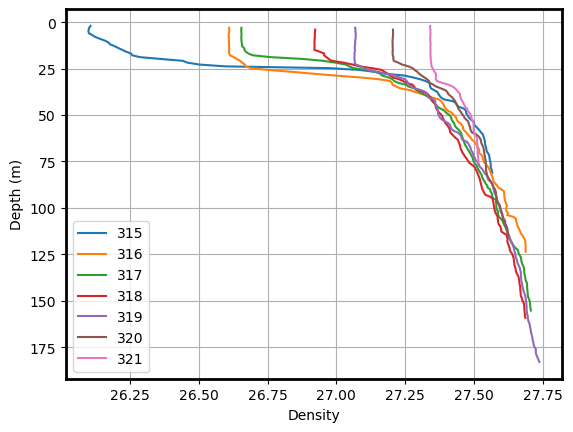

In [10]:
plt.figure()
for station in nordfjorden_section:
    plt.plot(CTD[station]['SIGTH'],-CTD[station]['z'],label=station)
plt.gca().invert_yaxis()
plt.xlabel('Density')
plt.ylabel('Depth (m)')
plt.grid()
plt.legend()

For many purposes, having the data stored in nested dictionaries is not very practical. There are several ways of how to re-order the data. You can either convert the data from a single station into a pandas dataframe, with the depth as the index and the variables as columns...

In [11]:
station_df = pd.DataFrame(CTD["315"])
station_df.index = -station_df['z']
print(station_df)

              P       D       T         C      OX   TURB      PAR        S  \
z                                                                            
1.978935    2.0   1.986  3.2520  3.006755  7.1366  1.026  0.42083  32.7980   
2.968396    3.0   2.965  3.2505  3.006168  7.0079  0.956  0.24578  32.7919   
3.957852    4.0   3.957  3.2432  3.005317  7.1258  0.947  0.20525  32.7885   
4.947303    5.0   4.948  3.2410  3.005070  7.1150  0.965  0.12799  32.7872   
5.936749    6.0   5.936  3.2446  3.005629  7.1050  1.031  0.10914  32.7897   
...         ...     ...     ...       ...     ...    ...      ...      ...   
77.164251  78.0  77.164  3.9835  3.233181  6.9514  0.412  0.10758  34.7105   
78.153347  79.0  78.154  3.9789  3.232807  6.9459  0.418  0.10762  34.7103   
79.142438  80.0  79.142  3.9658  3.231765  6.9497  0.389  0.10763  34.7113   
80.131524  81.0  80.131  3.9578  3.231127  6.9397  0.390  0.10765  34.7117   
81.120605  82.0  81.130  3.9530  3.230866  6.9439  0.413  0.1076

... or you can save the measurements of one particular variable from several stations into a dataframe, again with the depth s index, but the columns now represent the individual stations:

In [12]:
CTD_i,Z,_,_ = Oc.CTD_to_grid(CTD,nordfjorden_section,interp_opt=0)
df_oxygen = pd.DataFrame(CTD_i['OX'],index=Z,columns=nordfjorden_section)
print(df_oxygen)

                 315       316       317       318       319       320  \
1.978929         NaN       NaN       NaN       NaN       NaN       NaN   
2.984435    7.009811  6.889161  6.964168       NaN  2.469298       NaN   
3.989940    7.125450  6.979775  6.896843  6.900305  8.013913  7.025722   
4.995446    7.114513  7.031771  6.939756  6.942682  7.730563  6.995803   
6.000951    7.105753  6.905138  6.997242  6.952106  5.931921  7.096332   
...              ...       ...       ...       ...       ...       ...   
178.947921       NaN       NaN       NaN       NaN  6.708862       NaN   
179.953427       NaN       NaN       NaN       NaN  6.700885       NaN   
180.958932       NaN       NaN       NaN       NaN  6.689876       NaN   
181.964438       NaN       NaN       NaN       NaN  6.655787       NaN   
182.969944       NaN       NaN       NaN       NaN  6.604200       NaN   

                 321  
1.978929    6.098500  
2.984435    6.734114  
3.989940    6.585691  
4.995446    6.65894

Xarray datasets provide a good way to store multi-dimensional data, with several coordinates that can be used for accessing and plotting. The whole CTD-dictionary can be transformed into an xarray dataset using

In [17]:
ds_CTD = Oc.CTD_to_xarray(CTD)

In the dataset, each measured variable is defined as function of station and depth. During the transformation, all data has automatically been gridded onto the same 1-m depth grid.

In [14]:
print(ds_CTD)

<xarray.Dataset> Size: 32MB
Dimensions:       (station: 167, depth: 1733)
Coordinates:
    time          (station) datetime64[ns] 1kB 2023-09-27T09:52:10 ... 2023-1...
  * station       (station) <U7 5kB '65' '64' '63' '62' '40' ... '5' '4' '3' '1'
    ship_station  (station) int64 1kB 1431 1432 1433 1434 ... 1600 1601 1602
    lat           (station) float64 1kB 78.19 78.18 78.16 ... 78.62 78.64 78.66
    lon           (station) float64 1kB 13.62 13.63 13.66 ... 16.43 16.61 16.75
    bottom_depth  (station) float64 1kB 37.0 272.0 397.0 ... 107.0 176.0 188.0
  * depth         (depth) float64 14kB 1.0 2.0 3.0 ... 1.732e+03 1.733e+03
Data variables: (12/14)
    S             (depth, station) float64 2MB nan nan nan nan ... nan nan nan
    OX            (depth, station) float64 2MB nan nan nan nan ... nan nan nan
    D             (depth, station) float64 2MB nan nan nan nan ... nan nan nan
    P             (depth, station) float64 2MB nan nan nan nan ... nan nan nan
    PAR           (d

You might want to have a look at a map to see, where the stations are located (This function is so far only compatible with the CTD dictionary, not the xarray dataset).

<a list of 203 text.Text objects>


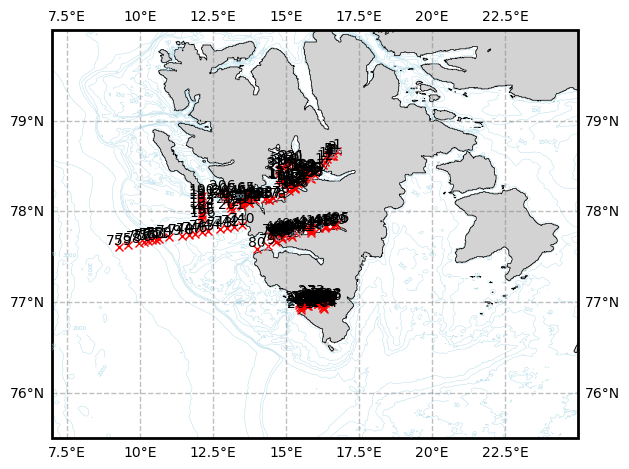

In [15]:
plt.figure()
Oc.plot_CTD_map(CTD, extent=[7.,25.,75.5,80.], topography=f"{path_data}Svalbard_map_data/bathymetry_svalbard.mat")

Like this, the map is not very helpful. Let's focus on the Nordfjorden section again:

<a list of 822 text.Text objects>


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


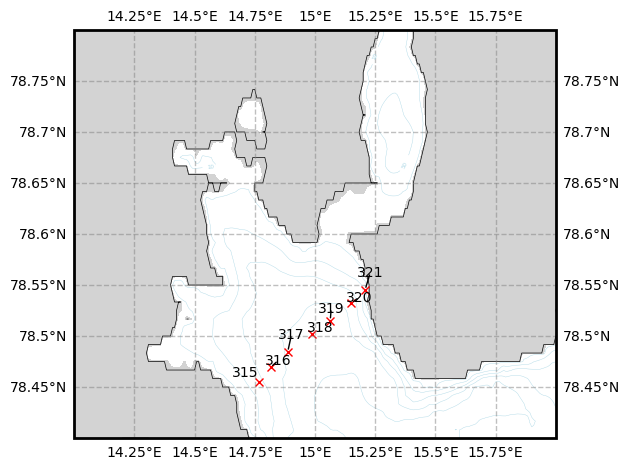

In [16]:
plt.figure()
Oc.plot_CTD_map(CTD, extent=[14.,16.,78.4,78.8], stations=nordfjorden_section, topography=f"{path_data}Svalbard_map_data/bathymetry_svalbard.mat",
                adjust_text=True)

Much better! Are you wondering how the temperature along this section looks like?

(<Axes: xlabel='Distance [km]', ylabel='Depth [m]'>,
 <matplotlib.contour.QuadContourSet at 0x19a75c1d0>)

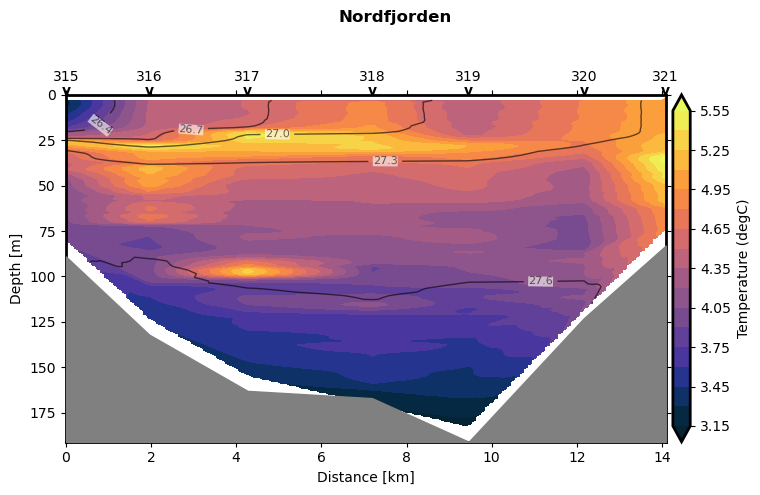

In [17]:
Oc.plot_CTD_single_section(CTD, nordfjorden_section, parameter='T',
                               clabel='Temperature (degC)',
                              cmap='cmo.thermal',section_name='Nordfjorden')

If you are not a fan of the interpolation, you can simply change the corrspeonding argument in the function call (Check the documentation using the help function!):

(<Axes: xlabel='Distance [km]', ylabel='Depth [m]'>,
 <matplotlib.contour.QuadContourSet at 0x19a8e6850>)

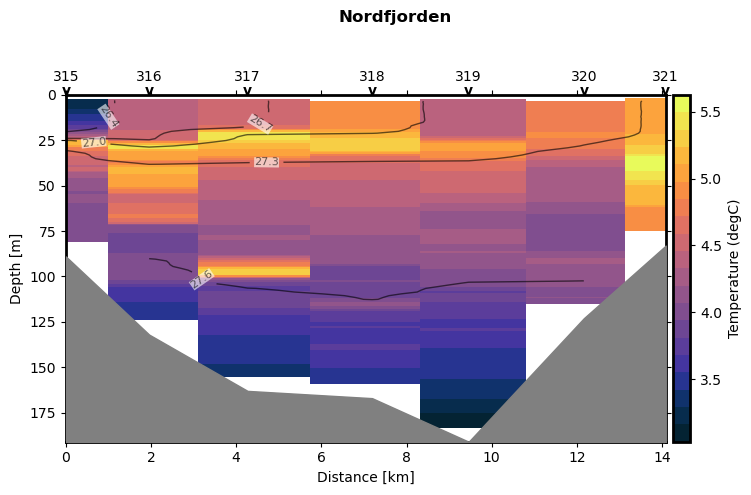

In [18]:
Oc.plot_CTD_single_section(CTD, nordfjorden_section, parameter='T',
                               clabel='Temperature (degC)',
                              cmap='cmo.thermal',section_name='Nordfjorden', interp_opt=0)

Finally, T-S diagrams are very useful to investigate e.g. the origin and interaction of water masses. A quick way to plot a T-S diagram of all stations in the Storfjorden section is the following function:

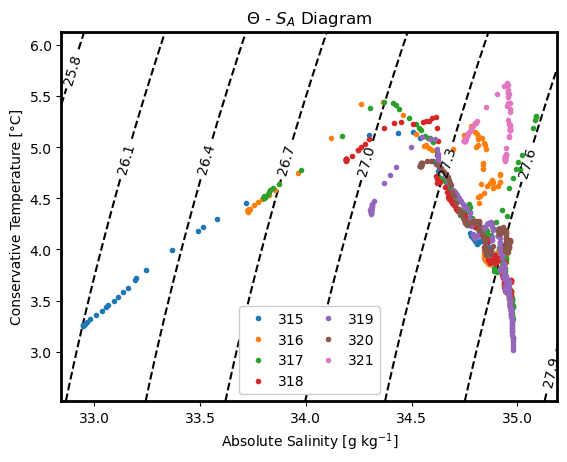

In [19]:
plt.figure()
Oc.plot_CTD_ts(CTD,nordfjorden_section)

If you want to adjust the plot to your individual needs, you can simply create an empty T-S diagram first, and then add the data manually. Instead of coloring the dots according to the station they were measured at, you can color them according to e.g. oxygen content instead:

(34.0, 35.5)

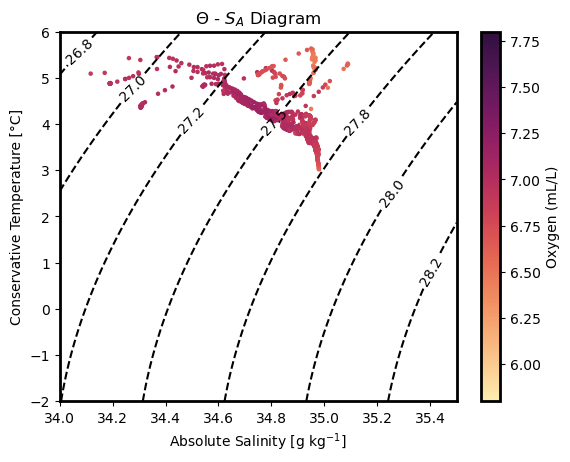

In [34]:
plt.figure()
Oc.create_empty_ts(T_extent=[-2., 6.],S_extent=[34.,35.5])
for station in nordfjorden_section:
    S = plt.scatter(CTD[station]['SA'],CTD[station]['CT'],
                s=5,c=CTD[station]['OX'],cmap='cmo.matter',
                   vmin=5.8,vmax=7.8)
plt.colorbar(S,label='Oxygen (mL/L)')
plt.xlim([34.,35.5])

### ADCP

Ship-mounted ADCP data will be processed by one of the teachers using a software package called CODAS and WinADCP. Furthermore, you will get data from the lowered ADCP.

The lowered ADCP measures one profile at every CTD station. In the data file, the stations are identified by their number from the ship log (not the UNIS station number). In order to co-locate LADCP and CTD data (give the individual profiles the same idientifier --> UNIS station number), you have to to provide the read function an additional dict with the translation:

In [13]:
stations2stations_dict = {CTD[i]["st"]: i for i in CTD.keys()}
ds_ladcp = Oc.read_LADCP(f"{path_data}LADCP/LADCP_HH202309_STA.mat", station_dict=stations2stations_dict, switch_xdim='station')
print(ds_ladcp)

<xarray.Dataset> Size: 9MB
Dimensions:       (station: 156, depth: 1734)
Coordinates:
  * station       (station) object 1kB '64' '63' '62' '40' ... '5' '4' '3' '1'
  * depth         (depth) float64 14kB 0.0 1.0 2.0 ... 1.732e+03 1.733e+03
    ship_station  (station) uint16 312B 1432 1433 1434 1435 ... 1600 1601 1602
    lat           (station) float64 1kB 78.18 78.16 78.14 ... 78.62 78.64 78.66
    lon           (station) float64 1kB 13.62 13.64 13.68 ... 16.43 16.61 16.75
    bottom_depth  (station) float64 1kB 291.0 399.0 392.0 ... 108.0 178.0 190.0
Data variables:
    u             (depth, station) float64 2MB nan nan nan nan ... nan nan nan
    v             (depth, station) float64 2MB nan nan nan nan ... nan nan nan
    u_detide      (depth, station) float64 2MB nan nan nan nan ... nan nan nan
    v_detide      (depth, station) float64 2MB nan nan nan nan ... nan nan nan
    time          (station) datetime64[ns] 1kB 2023-09-27T10:24:23 ... 2023-1...


The vessel-mounted ADCP measures constantly (not only at the CTD stations). Consequently, "station" is not a good dimsension for the dataset. We rather want to use time:

In [14]:
ds_codas = Oc.read_ADCP_CODAS(f"{path_data}VMADCP/CODAS/os75bb_short_STA.nc")
ds_winadcp = Oc.read_WinADCP(f"{path_data}VMADCP/WinADCP/AGF214_202309_031_STA.mat")
print(ds_winadcp)
print(ds_codas)

<xarray.Dataset> Size: 13MB
Dimensions:         (time: 3438, depth: 65)
Coordinates:
  * time            (time) datetime64[ns] 28kB 2023-09-28T18:15:27 ... 2023-1...
  * depth           (depth) float64 520B 16.0 24.0 32.0 ... 512.0 520.0 528.0
    lat             (time) float64 28kB 77.73 77.73 77.73 ... 78.66 78.66 78.66
    lon             (time) float64 28kB 11.39 11.37 11.34 ... 16.75 16.75 16.75
Data variables: (12/14)
    temperature     (time) float64 28kB 5.82 5.81 5.82 6.04 ... 4.27 4.27 4.26
    u_raw           (depth, time) float64 2MB 4.807 5.039 5.0 ... -0.123 0.086
    v_raw           (depth, time) float64 2MB 1.755 1.935 1.863 ... -0.068 0.031
    pg              (depth, time) float64 2MB 1.0 1.0 1.0 0.93 ... 0.0 0.0 0.0
    uship           (time) float64 28kB -4.961 -5.147 -5.186 ... 0.215 0.216
    vship           (time) float64 28kB -1.558 -1.722 -1.706 ... -0.17 -0.167
    ...              ...
    v_bottomtrack   (time) float64 28kB -1.604 -1.698 -1.711 ... -0.168 -0

You might notice that "depth" in the Codas dataset is not a dimension. This is because depending on the processing settings, the depth cells translate into different depth levels. With the following function, you can split the original dataset in subparts, which have a depth as dimension:

In [15]:
list_ds_codas = Oc.split_CODAS_resolution(ds_codas)
ds_codas = list_ds_codas[0]

In this example case, the list has only one element, so we simply overwrite the variable ds_codas. If several depth resolutions were used, the list might have more than one element, and you have to pick the element with the data you need.

In order to interpret the sections measured by the VM-ADCP without the influence of the tides, you need to de-tide the data:

ds_codas = Oc.detide_VMADCP(ds_codas, "{path_data}Tidal_models/", "Arc2kmTM")


You are typically only interested in one or two sections. You can extract one section from the LADCP and the CTD dataset like shown below. In case of the VM-data, use the ship_speed_threshold-parameter to discard data from times the ship was standing still (=at a station taking a CTD profile):

In [18]:
ds_CTD_nf = Oc.section_to_xarray(ds_CTD,nordfjorden_section)
ds_ladcp_nf = Oc.section_to_xarray(ds_ladcp, nordfjorden_section, ship_speed_threshold=1.5)

For the VM-ADCPs, it is a bit more complicated. Remember, those do not have the stations as dimension, but time. So you first have to figure out which time periods make up the section. Furthermore, you don't want to include data when the ship was drifting while doing a CTD profile, but only the times when the boat was actually sailing between the stations. You can use this little function to pick the right times:

In [39]:
Oc.check_VM_ADCP_map(ds_codas)

After picking the right time periods, you get the section like this:

In [40]:
ds_codas_nf = Oc.section_to_xarray(ds_codas, time_periods=[["2023-10-02T20:55", "2023-10-02T21:01"],
                                                            ["2023-10-02T21:13", "2023-10-02T21:23"],
                                                            ["2023-10-02T21:37", "2023-10-02T21:49"],
                                                            ["2023-10-02T22:07", "2023-10-02T22:13"],
                                                            ["2023-10-02T22:31", "2023-10-02T22:41"],
                                                            ["2023-10-02T22:57", "2023-10-02T23:03"]])

ds_winadcp_nf = Oc.section_to_xarray(ds_winadcp, time_periods=[["2023-10-02T20:55", "2023-10-02T21:01"],
                                                                ["2023-10-02T21:13", "2023-10-02T21:23"],
                                                                ["2023-10-02T21:37", "2023-10-02T21:49"],
                                                                ["2023-10-02T22:07", "2023-10-02T22:13"],
                                                                ["2023-10-02T22:31", "2023-10-02T22:41"],
                                                                ["2023-10-02T22:57", "2023-10-02T23:03"]])

/Users/lukasf/Documents/GitHub/unisacsi/unisacsi/Ocean.py:451: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/Users/lukasf/Documents/GitHub/unisacsi/unisacsi/Ocean.py:451: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.



Have a look at the currents in 50 m depth on a map:

<a list of 822 text.Text objects>


Text(<xarray.DataArray 'lon' ()> Size: 8B
array(15.20862778)
Coordinates:
    lat       float64 8B 78.54
    lon       float64 8B 15.21
    time      datetime64[ns] 8B 2023-10-02T23:03:28
    distance  float64 8B 14.32
Attributes:
    long_name:      Longitude
    units:          degrees_east
    C_format:       %9.4f
    standard_name:  longitude
    data_min:       9.236555555555556
    data_max:       16.75275, <xarray.DataArray 'lat' ()> Size: 8B
array(78.54427222)
Coordinates:
    lat       float64 8B 78.54
    lon       float64 8B 15.21
    time      datetime64[ns] 8B 2023-10-02T23:03:28
    distance  float64 8B 14.32
Attributes:
    long_name:      Latitude
    units:          degrees_north
    C_format:       %9.4f
    standard_name:  latitude
    data_min:       76.9163138888889
    data_max:       78.66320833333333, 'B')

<Figure size 900x900 with 0 Axes>

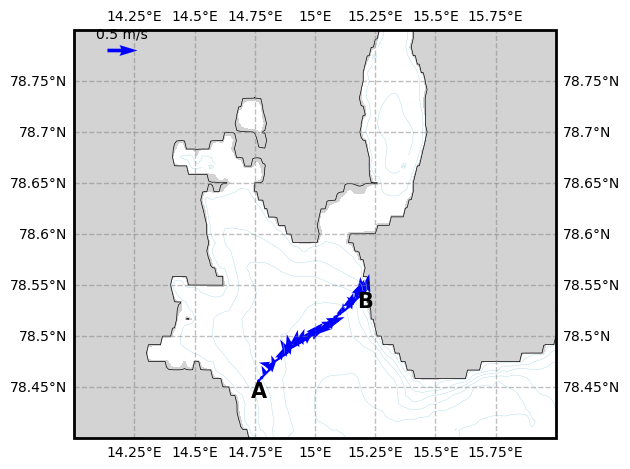

In [41]:
data_proj = ccrs.PlateCarree()
plt.figure(figsize=(9,9))

fig, ax = Oc.plot_empty_map(extent=[14.,16.,78.4,78.8], topography=f"{path_data}Svalbard_map_data/bathymetry_svalbard.mat")

# First plot the shiptrack
ax.plot(ds_codas_nf.lon,ds_codas_nf.lat,transform=data_proj, color='b')

#Then plot the surface velocity as arrows
q = ax.quiver(ds_codas_nf.lon,ds_codas_nf.lat, ds_codas_nf.u.sel(depth=50., method="nearest"), ds_codas_nf.v.sel(depth=50., method="nearest"), scale=8., transform=data_proj, color = 'b')
# Put a legend for the arrows
plt.quiverkey(q,0.1,0.95,0.5,'0.5 m/s',color='blue',labelcolor='black',
                  transform=plt.gca().transAxes)

# Indicate on the map, where the section starts, and where it ends
ax.text(ds_codas_nf.lon[0],ds_codas_nf.lat[0],'A',transform=data_proj,fontweight='bold',
       horizontalalignment='center',verticalalignment='top',
       fontsize=15)
ax.text(ds_codas_nf.lon[-1],ds_codas_nf.lat[-1],'B',transform=data_proj,fontweight='bold',
       horizontalalignment='center',verticalalignment='top',
       fontsize=15)

And to combine CTD and ADCP data into the same section plots, use this function:

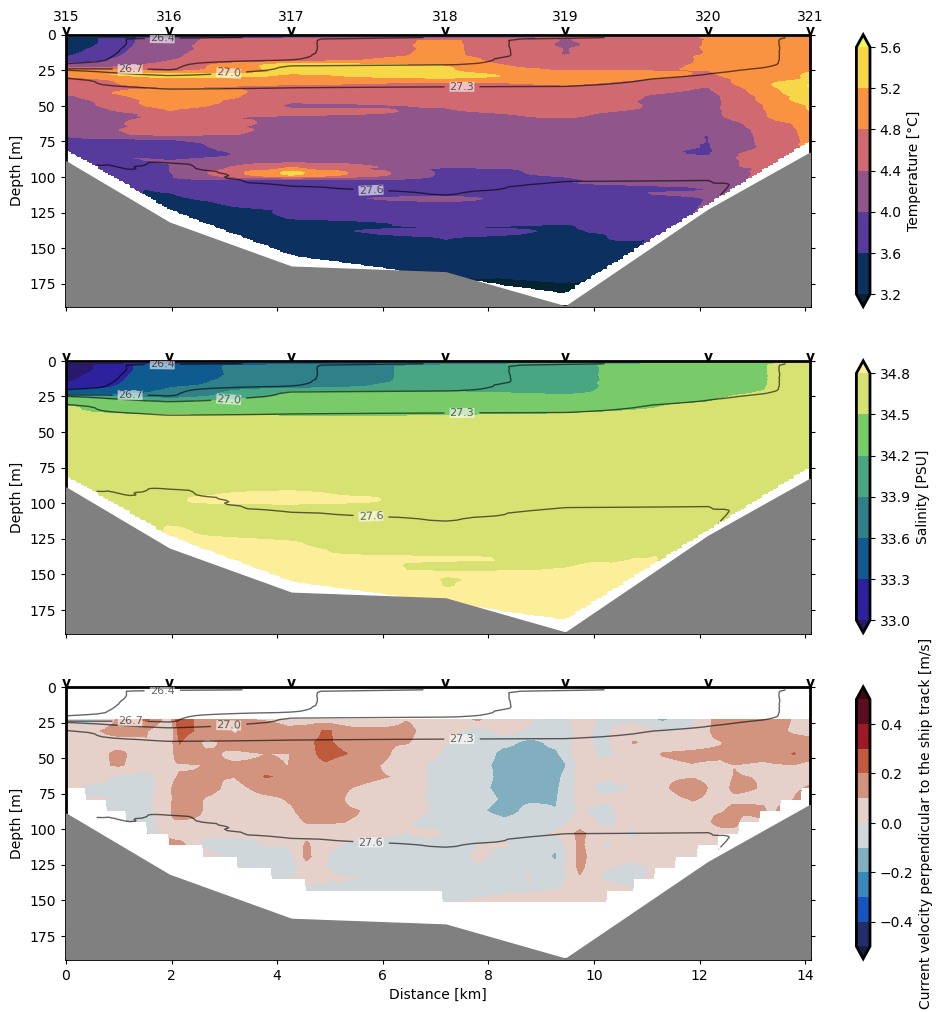

In [45]:
fig, axes, pics = Oc.plot_xarray_sections([ds_CTD_nf["T"], ds_CTD_nf["S"], ds_codas_nf["crossvel"]],
                          [cmo.cm.thermal, cmo.cm.haline, cmo.cm.balance],
                          [None, None, np.arange(-0.5, 0.50001, 0.1)],
                          ds_CTD_nf["SIGTH"], interp=True)

### Mooring

During the AGF-214 cruise, you will recover and re-deploy a set of moorings, which constantly monitor the in- and outflow of water in the mouth of Isfjorden. The following code snippets can help you to handle the data.

There are functions available to read the data from all the individual instruments deployed on the mooring. Furthermore, you have one function available to afterwards combine the hydropgraphy data (T,S,SIGTH) into an xarray dataset.

In [46]:
dict_mooring = {
    31: Oc.read_SBE37(f"{path_data}Mooring/SBE37/SBE37SM-RS232_03723000_2023_09_28.cnv"),
    49: Oc.read_RBR(f"{path_data}Mooring/RBRconcerto/206125_20230928_0909.rsk"),
    64: Oc.read_RBR(f"{path_data}/Mooring/RBRsolo/205993_20230928_0641_upgraded.rsk")
# the complete mooring contains many more instruments, but you get how it works ;)
}
ds_mooring = Oc.mooring_into_xarray(dict_mooring)

No pressure channel available, sea pressure will be set to 0.
/Users/lukasf/Documents/GitHub/unisacsi/unisacsi/Ocean.py:504: FutureWarning:

'MIN' is deprecated and will be removed in a future version, please use 'min' instead.



In [47]:
print(ds_mooring)

<xarray.Dataset> Size: 2MB
Dimensions:  (depth: 3, time: 25854)
Coordinates:
  * depth    (depth) float64 24B 31.0 49.0 64.0
  * time     (time) datetime64[ns] 207kB 2022-10-04T10:00:00 ... 2023-09-28T1...
Data variables:
    T        (time, depth) float64 620kB 4.643 4.773 4.28 ... 18.31 nan nan
    S        (time, depth) float64 620kB 33.75 33.74 nan ... 0.0116 nan nan
    SIGTH    (time, depth) float64 620kB 26.72 26.7 nan 26.7 ... -1.453 nan nan


In [48]:
ds_mooring_grid = ds_mooring.interpolate_na("time")
ds_mooring_grid = ds_mooring.interp({"depth": np.arange(32., 64., 1.)})
print(ds_mooring_grid)

<xarray.Dataset> Size: 20MB
Dimensions:  (time: 25854, depth: 32)
Coordinates:
  * time     (time) datetime64[ns] 207kB 2022-10-04T10:00:00 ... 2023-09-28T1...
  * depth    (depth) float64 256B 32.0 33.0 34.0 35.0 ... 60.0 61.0 62.0 63.0
Data variables:
    T        (time, depth) float64 7MB 4.65 4.658 4.665 4.672 ... nan nan nan
    S        (time, depth) float64 7MB 33.75 33.75 33.74 33.74 ... nan nan nan
    SIGTH    (time, depth) float64 7MB 26.72 26.72 26.72 26.72 ... nan nan nan


Now it is very easy to plot time series from a certain depth or Hovmoeller plots of the different variables:

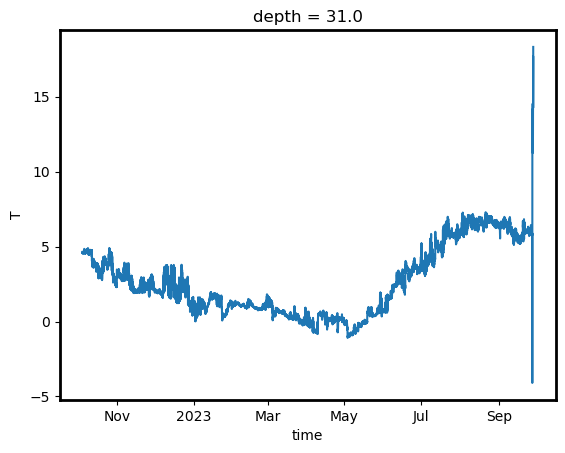

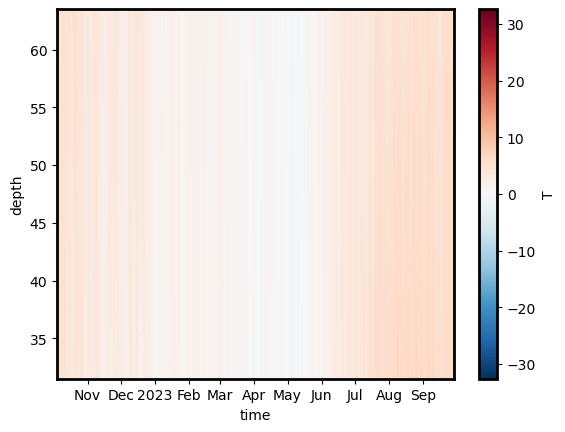

In [49]:
plt.figure()
ds_mooring["T"].sel(depth=31.).plot(x="time")

plt.figure()
ds_mooring_grid["T"].plot(x="time")

Have a look at the xarray documentation online to for further help on how to plot the data in a nicer way!

You also see that the last few data points are off, as the instruments were out of the water after the recovery. You should cut the time series:

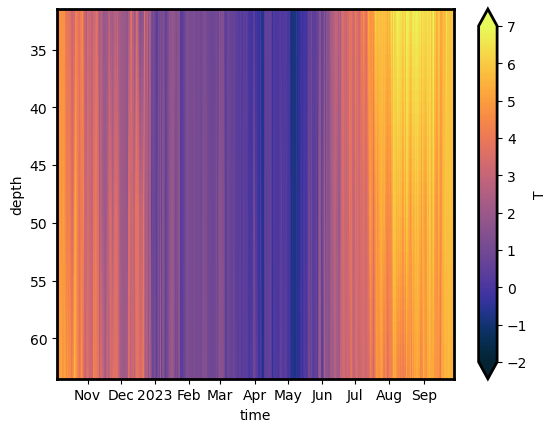

In [50]:
ds_mooring = ds_mooring.sel(time=slice("2022-09-28T10:00","2023-09-28T06:00:00"))
ds_mooring_grid = ds_mooring_grid.sel(time=slice("2022-09-28T10:00","2023-09-28T06:00:00"))

fig, ax = plt.subplots()
ds_mooring_grid["T"].plot(ax=ax, x="time", vmin=-2., vmax=7., cmap=cmo.cm.thermal)
ax.invert_yaxis()

### Tidal analysis

The toolbox contains a few functions to do spectral and tidal analyses. If you suspect a periodic signal in a time series (e.g. a tidal signal), the first thing to do is typically to look at a spectrum, to identify the frequencies and match them with theoretical knowledge.

/Users/lukasf/Documents/GitHub/unisacsi/unisacsi/Ocean.py:1325: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



<Axes: xlabel='TIMESTAMP'>

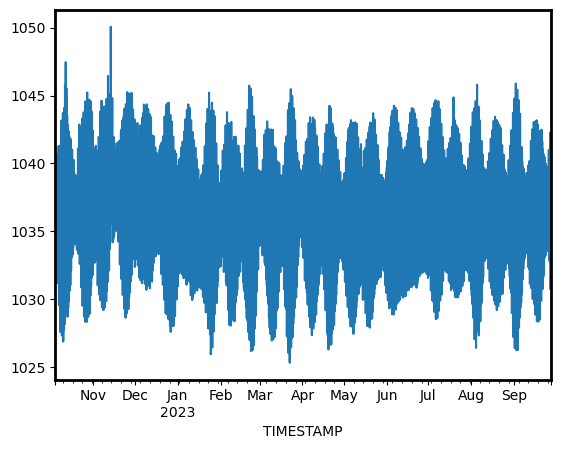

In [51]:
df = Oc.read_Seaguard(f"{path_data}Mooring/SeaGuard/Seaguard_2370.txt")
df = df[:"2023-09-27T15"]
df["P"].plot()

The following set of functions can be used to calcualte a spectrum of a time series and then plot it together with a set of known natural tidal frequencies.

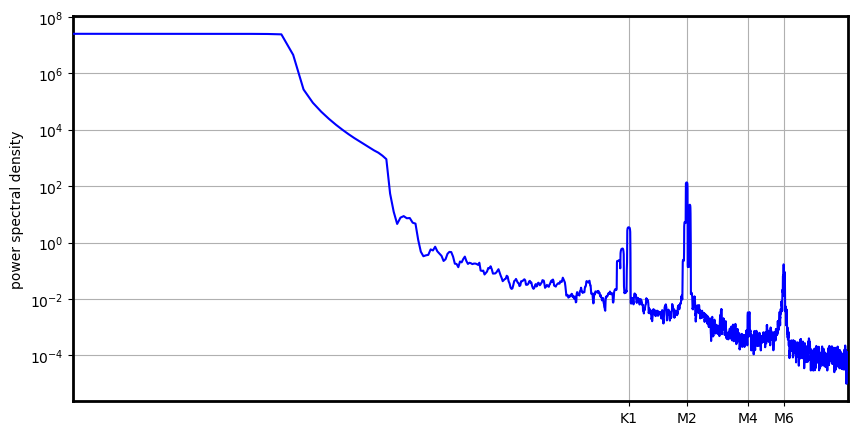

In [52]:
s_mt = Oc.calculate_tidal_spectrum(df["P"])
fig, ax = Oc.plot_tidal_spectrum(s_mt, constituents=["M2", "K1", "M4", "M6"])

Once you have identified the most important tidal frequencies in the time series, you probably want to do a harmonic analysis and remove the tidal variations from the time series:

In [53]:
amplitude, phase, detided, pure_tides = Oc.tidal_harmonic_analysis(df["P"], constituents=["M2", "S2", "N2", "K1", "O1", "M4", "M6", "MK3", "S4", "MN4"], remove_mean=False)

If you are not sure, which tidal frequencies to include in the harmonic analysis, you start with all available ones.

In [54]:
constis = list(uptide.tidal.omega.keys())
amplitude, phase, detided, pure_tides = Oc.tidal_harmonic_analysis(df["P"], constituents=constis, remove_mean=False)

Here the time series before and after the tidal removal:

<Axes: xlabel='TIMESTAMP'>

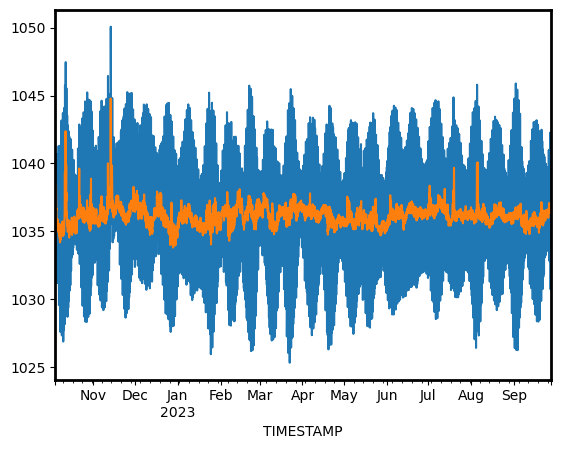

In [55]:
df["P"].plot()
detided.plot()

The amplitudes of the individual constituents tell you how important they are:

In [56]:
s_tides = pd.Series(amplitude, index=constis)
s_tides = s_tides.sort_values(ascending=False)
print(s_tides)

M2         5.128845
S2         1.974480
N2         1.004221
K1         0.696480
K2         0.580029
SA         0.568520
SSA        0.484124
MM         0.318258
O1         0.304756
MF         0.286374
P1         0.210072
NU2        0.204153
M6         0.191064
Q1         0.179194
MU2        0.163432
L2         0.146212
T2         0.137482
2N2        0.133908
2MS6       0.128339
MSF        0.083886
S1         0.076227
LAMBDA2    0.054581
R2         0.051329
MSQM       0.040981
2MK6       0.038061
MSM        0.037855
M1         0.036013
MSN2       0.030220
MO3        0.027045
MS4        0.026591
M4         0.023291
J1         0.021937
ETA2       0.020789
MNS2       0.016478
M3         0.016351
EPS2       0.016035
3M2S2      0.014533
2SM2       0.012498
MTM        0.011174
MT         0.011174
MFM        0.011174
M8         0.009307
MK3        0.008817
MKS2       0.007607
M5         0.005340
S4         0.003734
M11        0.003717
MN4        0.003396
M9         0.002744
M12        0.002551


Finally, by applying the harmonic analysis to the current components, you can have a look at the tidal ellipses:

<a list of 791 text.Text objects>


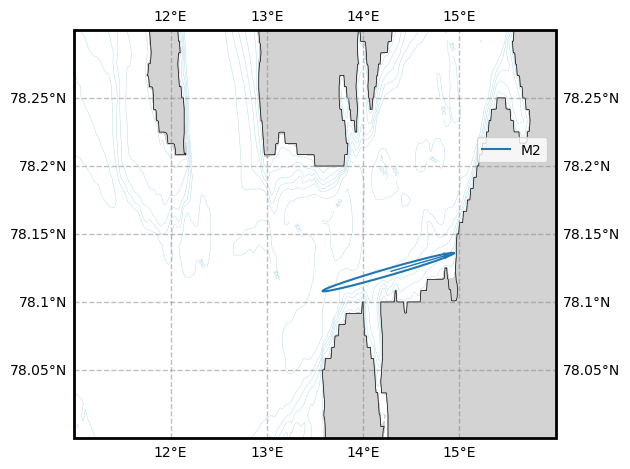

In [57]:
au, pu, _, _ = Oc.tidal_harmonic_analysis(df["U"], constituents=["M2"], remove_mean=False)
av, pv, _, _ = Oc.tidal_harmonic_analysis(df["V"], constituents=["M2"], remove_mean=False)

a,b,theta,g = uptide.tidal_ellipse_parameters(au, pu, av, pv)
fig, ax_map, ax_ellipse = Oc.plot_map_tidal_ellipses(a,b,theta,g, ["M2"], lat_center=78.122, lon_center=14.26, map_extent=[11., 16., 78., 78.3], topography=f"{path_data}Svalbard_map_data/bathymetry_svalbard.mat")


## Meteorology

### Download AROME-Arctic model data

You can download model data from AROME-Arctic using the following functions. The configurations are set in an extra configuration file (also provided on github)

In [60]:
#download_MET_model_static_fields(f"{path_data}AROME_ARCTIC/config_model_download.yml")
download_MET_model_data(f"{path_data}AROME_ARCTIC/config_model_download.yml")

############################################################
start downloading data from 2022-10-22
############################################################


/Users/lukasf/Documents/GitHub/unisacsi/unisacsi/MET_model_download.py:173: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/22/arome_arctic_det_2_5km_20221022T00Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/22/arome_arctic_det_2_5km_20221022T03Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/22/arome_arctic_det_2_5km_20221022T06Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/22/arome_arctic_det_2_5km_20221022T09Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/22/arome_arctic_det_2_5km_20221022T12Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/22/arome_arctic_det_2_5km_20221022T15Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/22/arome_arctic_det_2_5km_20221022T18Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/22/arome_arctic_det_2_5km_20221022T21Z.nc.
########

/Users/lukasf/Documents/GitHub/unisacsi/unisacsi/MET_model_download.py:173: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/23/arome_arctic_det_2_5km_20221023T00Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/23/arome_arctic_det_2_5km_20221023T03Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/23/arome_arctic_det_2_5km_20221023T06Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/23/arome_arctic_det_2_5km_20221023T09Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/23/arome_arctic_det_2_5km_20221023T12Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/23/arome_arctic_det_2_5km_20221023T15Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/23/arome_arctic_det_2_5km_20221023T21Z.nc.
############################################################
start downloading data from 2022-10-24
################################

/Users/lukasf/Documents/GitHub/unisacsi/unisacsi/MET_model_download.py:173: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/24/arome_arctic_det_2_5km_20221024T00Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/24/arome_arctic_det_2_5km_20221024T03Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/24/arome_arctic_det_2_5km_20221024T06Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/24/arome_arctic_det_2_5km_20221024T09Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/24/arome_arctic_det_2_5km_20221024T12Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/24/arome_arctic_det_2_5km_20221024T15Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/24/arome_arctic_det_2_5km_20221024T18Z.nc.
Done downloading https://thredds.met.no/thredds/dodsC/aromearcticarchive/2022/10/24/arome_arctic_det_2_5km_20221024T21Z.nc.


### Time series plots

Most of the data we sample during the meteorology fieldwork is simple time series data. Functions to read the data are available in the Meteo module (Check the docs!). The following code is just an example of how to read and plot the data from a radiometer or several Tinytags:

                     RECORD  CM3Up_Avg [W/meter²]  CM3Dn_Avg [W/meter²]  \
TIMESTAMP                                                                 
2022-02-11 11:45:00     815                 0.918                 0.955   
2022-02-11 11:50:00     816                 2.023                 2.079   
2022-02-11 11:55:00     817                 2.210                 2.191   
2022-02-11 12:00:00     818                 1.124                 1.124   
2022-02-11 12:05:00     819                 1.124                 1.124   

                     CG3Up_Avg [W/meter²]  CG3Dn_Avg [W/meter²]  \
TIMESTAMP                                                         
2022-02-11 11:45:00                -15.69                -6.402   
2022-02-11 11:50:00                -10.93                -4.728   
2022-02-11 11:55:00                -10.49                -5.062   
2022-02-11 12:00:00                -12.03                -5.232   
2022-02-11 12:05:00                -13.26                -5.652   

    

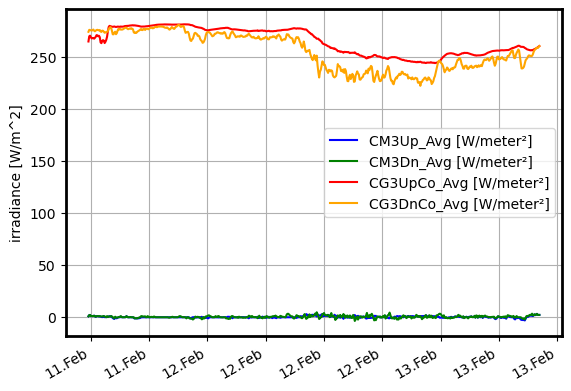

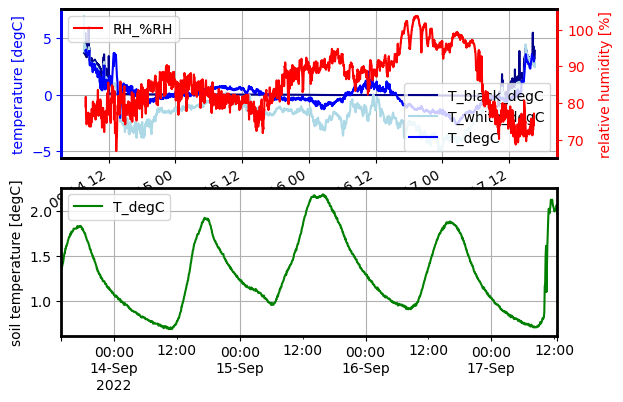

In [64]:
# Radiation
df_rad = Met.read_Campbell_TOA5(f"{path_data}Radiation_SEB/TOA5_19688.rad_2022_02_11_1145.dat")
print(df_rad.head())
    
fig, ax = plt.subplots(1,1)
with pd.plotting.plot_params.use('x_compat', True):
    df_rad.plot(y="CM3Up_Avg [W/meter²]", ax=ax, c="b")
    df_rad.plot(y="CM3Dn_Avg [W/meter²]", ax=ax, c="g")
    df_rad.plot(y="CG3UpCo_Avg [W/meter²]", ax=ax, c="r")
    df_rad.plot(y="CG3DnCo_Avg [W/meter²]", ax=ax, c="orange")
ax.set_xlabel(None)
ax.set_ylabel("irradiance [W/m^2]")
ax.grid("both")
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d.%b'))



# TinyTags
df_TT = Met.read_Tinytag(f"{path_data}TinyTags/20220917_TT3.txt", "TT")
df_TH = Met.read_Tinytag(f"{path_data}TinyTags/20220917_TH6.txt", "TH")
df_CEB = Met.read_Tinytag(f"{path_data}TinyTags/20220917_CEB1.txt", "CEB")

fig, (ax_T, ax_CEB) = plt.subplots(2,1)
ax_RH = ax_T.twinx()
df_TT.plot(y="T_black_degC", ax=ax_T, c="darkblue")
df_TT.plot(y="T_white_degC", ax=ax_T, c="lightblue")
df_TH.plot(y="T_degC", ax=ax_T, c="b")
df_TH.plot(y="RH_%RH", ax=ax_RH, c="r")
ax_T.set_xlabel(None)
ax_T.set_ylabel("temperature [degC]", c="b")
ax_RH.set_ylabel("relative humidity [%]", c="r")
ax_RH.spines['left'].set_color('b')
ax_RH.spines['right'].set_color('r')
ax_T.tick_params(axis='y', colors="b", labelcolor="b")
ax_RH.tick_params(axis='y', colors="r", labelcolor="r")
ax_T.grid("both")
ax_T.legend(loc="lower right")
ax_RH.legend(loc="upper left")

df_CEB.plot(y="T_degC", ax=ax_CEB, c="g")
ax_CEB.set_xlabel(None)
ax_CEB.set_ylabel("soil temperature [degC]")
ax_CEB.grid()

Besides time series plots, you might want to plot data on a map. Examples are model data from AROME-Arctic or IWIN measurements from the boats on Isfjorden. The Meteo module provides a set of functions to create different kinds of maps, please check the docs and decide, which type might be suited best for your specific plot. An example:

Text(0, 0.5, '2m temperature')

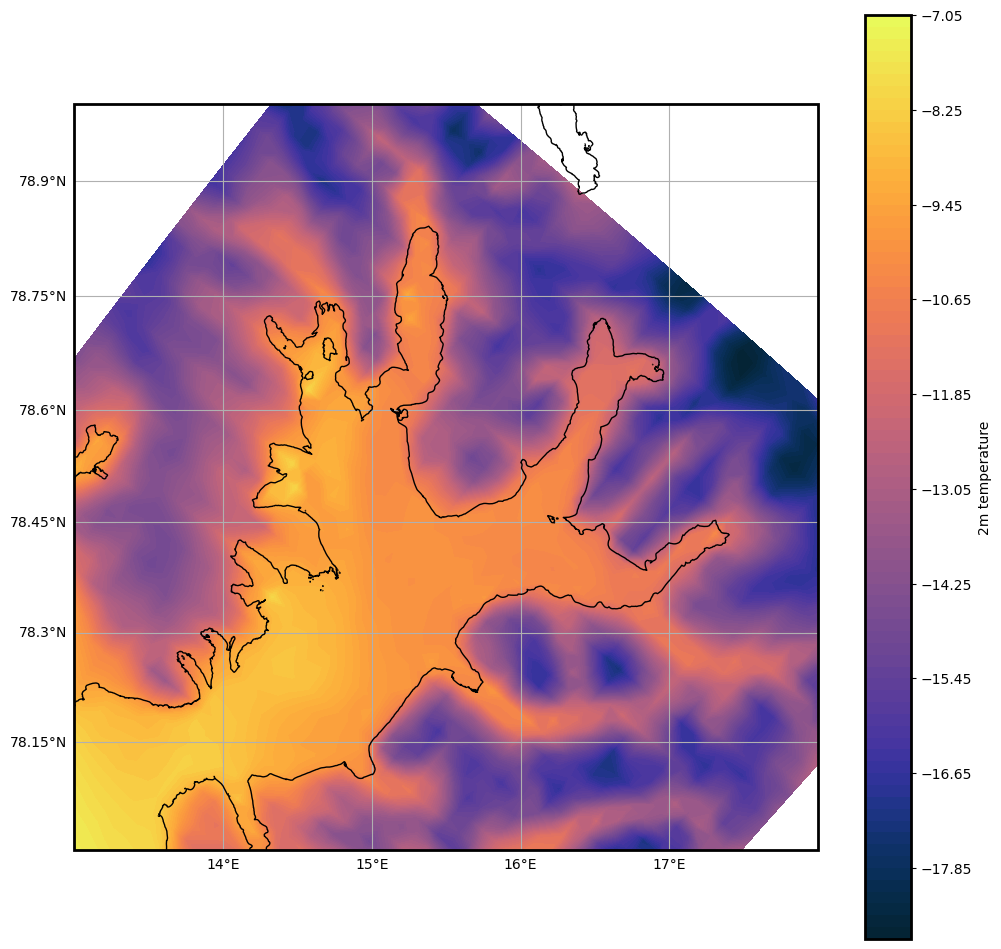

In [61]:
aa = Met.read_AROME(f"{path_data}AROME_ARCTIC/AA_nearsurface_2p5km_20220503.nc")
    
fig, ax = Met.initialize_empty_map(lat_limits=[78., 79.], lon_limits=[13., 18.])
fig, ax = Met.map_add_coastline(fig, ax, option=1, color="k", lat_limits=[78., 79.], lon_limits=[13., 18.], path_mapdata=f"{path_data}Svalbard_map_data/")

pic = ax.contourf(aa.longitude, aa.latitude, aa.air_temperature_2m.sel(time="2022-05-03 12:00:00")-273.15, levels=100, cmap=cmo.cm.thermal, transform=ccrs.PlateCarree())
cbar = plt.colorbar(pic, ax=ax)
cbar.ax.set_ylabel("2m temperature")